# Main Diffusion Script
### Imports

In [3]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
except:
    !pip install audio-diffusion-pytorch
try: 
    import optuna, plotly
except:
    !pip install optuna
    !pip install plotly


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
import optuna, plotly
from optuna.importance import get_param_importances
from optuna.visualization import plot_param_importances

# Utils
import numpy as np
from numpy import ndarray
import logging
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

c:\Users\finia\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

General

In [8]:
remote_kernel: bool = False #Set to true if using a remote Kernel changes the file structure
model_name: str = "diffusion_full_v4"
training_data_name: str = "training_mel_24"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [5]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [9]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 1400
n_validation_samples: int = 50
tensor_dim: list = [1, 96, 512] #B, C, H = Batch, Freq bins, Time domain

batch_size: int = 64


learning_rate: float = 0.000479
betas: tuple[float] = (0.57, 0.76)
epochs: int = 1000
restart_training: bool = True
checkpoint_freq: int = 10

### Data Loading

In [10]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))
np.random.seed(50)
np.random.shuffle(file)
data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-06-14 11:12:54,513 - INFO - Data loaded with shape: (3896, 96, 512)


### Setup

Model Creation

Optuna

In [6]:
def define_model(trial: optuna.Trial) -> nn.Module:
    base_channels = trial.suggest_int("base_channels", 64, 256, step=32)
    channels = [base_channels, base_channels, base_channels * 2, base_channels * 2, base_channels * 4, base_channels * 4, base_channels * 4]
    attention_heads = trial.suggest_int("attention_heads", 4, 16, step=4)
    attention_features = trial.suggest_int("attention_features", 128, 512, step=64)
    factor_pattern_str = trial.suggest_categorical("factor_pattern", ["1_1_2_2_2_2_2", "1_2_2_2_2_2_2", "2_2_2_2_2_2_2"])
    items_pattern_str = trial.suggest_categorical("items_pattern", ["1_2_2_2_2_2_2", "1_1_2_2_3_3_3", "2_2_2_2_2_2_2"
    ])
    attention_pattern_str = trial.suggest_categorical("attention_pattern", ["0_0_1_1_1_1_1", "0_0_0_1_1_1_1", "0_0_0_0_1_1_1"])
    
    factor_pattern = [int(x) for x in factor_pattern_str.split("_")]
    items = [int(x) for x in items_pattern_str.split("_")]
    attention_pattern = [int(x) for x in attention_pattern_str.split("_")]
    u_net = UNetV0
    u_net = DiffusionModel(
        net_t=u_net,
        in_channels=96,
        channels=channels,
        factors=factor_pattern,
        items=items,
        attentions=attention_pattern,
        attention_features=attention_features,
        attention_heads=attention_heads,
        diffusion_t=VDiffusion,
        sampler_t=VSampler,
        dim=1
    )
    return u_net

def objective(trial: optuna.Trial) -> float:
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_int("batch_size", 8, 64, step=8)
    b1 = trial.suggest_float("b1", 0.4, 0.99)
    b2 = trial.suggest_float("b2", 0.4, 0.999)
    model = define_model(trial).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(b1, b2))

    data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
    validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
    
    n_epochs = 10
    if device == "cuda":
        scaler = torch.cuda.amp.GradScaler()
    else:
        scaler = torch.amp.GradScaler(device=device)

    best_val_loss: float = float('inf')
    for e in range(n_epochs):
        total_loss: float = 0
        validation_loss: float = 0

        for b_idx, (x, _) in enumerate(data_loader):
            if x.dim() == 2:
                x = x.to(device).unsqueeze(1)
            else:
                x = x.to(device)
            with torch.autocast(device_type=device):
                loss = model(x)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        if validation_dataloader is not None:
            model.eval()
            for (x, _) in validation_dataloader:
                if x.dim() == 2:
                    x = x.to(device).unsqueeze(1)
                else:
                    x = x.to(device)
                with torch.no_grad():
                    loss = model(x)
                    validation_loss += loss.item()
            validation_loss /= len(validation_dataloader)
            model.train()

        total_loss /= len(data_loader)
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
        trial.report(validation_loss, e)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return best_val_loss

def run_optim(n_trials: int, name: str ="main_study") -> None:
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(),study_name=name)
    study.optimize(objective, n_trials=n_trials)
    logger.info("Finished Study")
    logger.info(f"Best trial: {study.best_trial} with value: {study.best_trial.value} using params:")
    for key, val in study.best_trial.params.items():
        logger.info(f"{key}:{val}")
    
    logger.info("Param importance:")
    for param, importance in get_param_importances(study).items():
            logger.info(f"{param}: {importance:.4f}")
    fig = plot_param_importances(study)
    fig.show()


In [7]:
run_optim(n_trials=150)

[I 2025-06-11 15:56:28,021] A new study created in memory with name: main_study
[W 2025-06-11 15:56:36,173] Trial 0 failed with parameters: {'lr': 1.8691681443593347e-05, 'batch_size': 24, 'b1': 0.6042011343010014, 'b2': 0.9445525101088139, 'base_channels': 256, 'attention_heads': 16, 'attention_features': 192, 'factor_pattern': '2_2_2_2_2_2_2', 'items_pattern': '1_2_2_2_2_2_2', 'attention_pattern': '0_0_0_0_1_1_1'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_14894/2158810189.py", line 65, in objective
    total_loss += loss.item()
                  ^^^^^^^^^^^
KeyboardInterrupt
[W 2025-06-11 15:56:36,176] Trial 0 failed with value None.


KeyboardInterrupt: 

In [ ]:
u_net = UNetV0
u_net = DiffusionModel(
    net_t=u_net,
    in_channels=96,
    channels=[256, 256, 512, 512, 1024, 1024, 1024],
    factors=[1, 2, 2, 2, 2, 2, 2],
    items=[1, 1, 2, 2, 3, 3, 3],
    attentions=[0, 0, 1, 1, 1, 1, 1],
    attention_features=192,
    attention_heads=12,
    diffusion_t=VDiffusion,
    sampler_t=VSampler,
    dim=1
).to(device)


Model Loading

In [9]:
optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-06-11 15:57:02,312 - INFO - Model diffusion_full_v3 loaded with ~404.1M Parameters


Initiate Trainer

In [10]:
trainer = Trainer(u_net, optimizer, scheduler, device, n_dims=1)

### Training

2025-06-11 15:57:02,519 - INFO - Training started on cuda
2025-06-11 15:57:08,912 - INFO - Epoch 001: Avg. Loss: 7.60567e-01 Avg. val. Loss: 1.89513e-01 Remaining Time: 00h 53min 05s LR: 4.69420e-04 
2025-06-11 15:57:14,160 - INFO - Epoch 002: Avg. Loss: 1.68001e-01 Avg. val. Loss: 1.34962e-01 Remaining Time: 00h 48min 16s LR: 4.60032e-04 
2025-06-11 15:57:19,529 - INFO - Epoch 003: Avg. Loss: 1.33498e-01 Avg. val. Loss: 1.41977e-01 Remaining Time: 00h 46min 56s LR: 4.50831e-04 
2025-06-11 15:57:25,139 - INFO - Epoch 004: Avg. Loss: 1.29621e-01 Avg. val. Loss: 1.25362e-01 Remaining Time: 00h 46min 43s LR: 4.41814e-04 
2025-06-11 15:57:30,523 - INFO - Epoch 005: Avg. Loss: 1.13682e-01 Avg. val. Loss: 8.37322e-02 Remaining Time: 00h 46min 11s LR: 4.32978e-04 
2025-06-11 15:57:35,817 - INFO - Epoch 006: Avg. Loss: 1.11099e-01 Avg. val. Loss: 1.17528e-01 Remaining Time: 00h 45min 40s LR: 4.24319e-04 
2025-06-11 15:57:41,502 - INFO - Epoch 007: Avg. Loss: 1.12249e-01 Avg. val. Loss: 9.96630

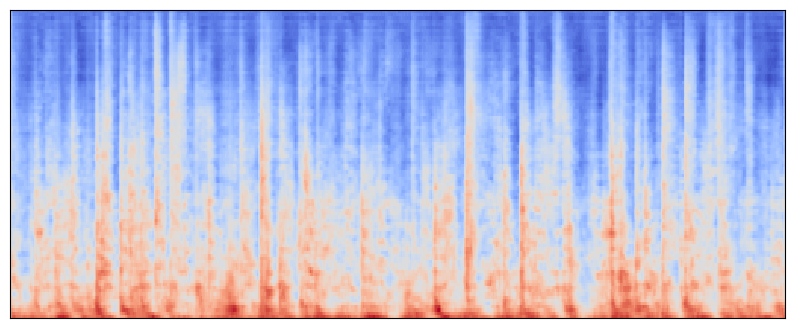

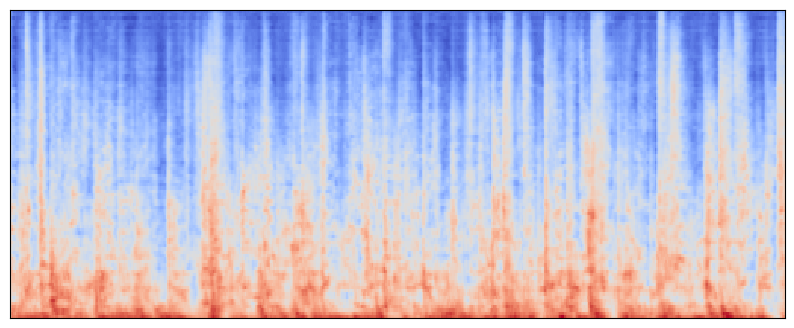

2025-06-11 15:58:57,951 - INFO - Epoch 020: Avg. Loss: 1.12799e-01 Avg. val. Loss: 1.22973e-01 Remaining Time: 00h 44min 18s LR: 3.19784e-04 
2025-06-11 15:59:08,493 - INFO - Epoch 021: Avg. Loss: 1.03609e-01 Avg. val. Loss: 1.16920e-01 Remaining Time: 00h 44min 11s LR: 3.13389e-04 
2025-06-11 15:59:14,397 - INFO - Epoch 022: Avg. Loss: 1.08331e-01 Avg. val. Loss: 8.59566e-02 Remaining Time: 00h 44min 14s LR: 3.07121e-04 
2025-06-11 15:59:19,779 - INFO - Epoch 023: Avg. Loss: 1.06499e-01 Avg. val. Loss: 1.44305e-01 Remaining Time: 00h 44min 05s LR: 3.00978e-04 
2025-06-11 15:59:25,165 - INFO - Epoch 024: Avg. Loss: 1.04131e-01 Avg. val. Loss: 1.16496e-01 Remaining Time: 00h 43min 56s LR: 2.94959e-04 
2025-06-11 15:59:30,637 - INFO - Epoch 025: Avg. Loss: 9.82217e-02 Avg. val. Loss: 1.09702e-01 Remaining Time: 00h 43min 49s LR: 2.89060e-04 
2025-06-11 15:59:36,299 - INFO - Epoch 026: Avg. Loss: 1.02999e-01 Avg. val. Loss: 1.14116e-01 Remaining Time: 00h 43min 46s LR: 2.83278e-04 
2025-0

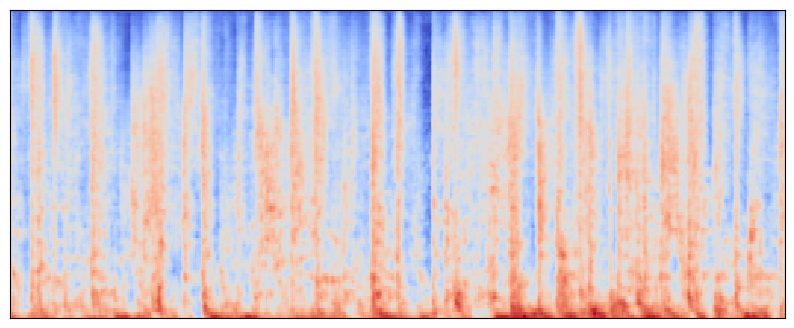

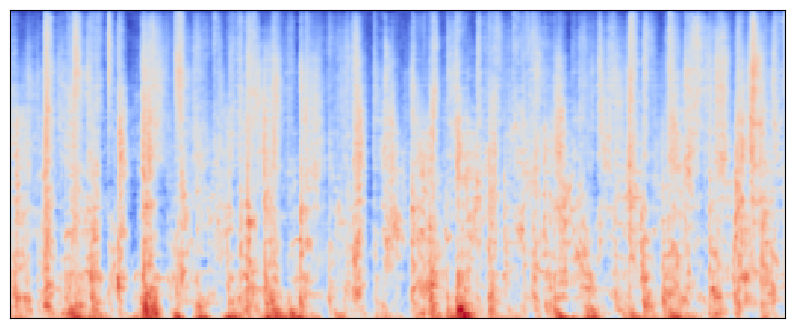

2025-06-11 16:00:58,254 - INFO - Epoch 040: Avg. Loss: 1.03669e-01 Avg. val. Loss: 8.73767e-02 Remaining Time: 00h 42min 22s LR: 2.13490e-04 
2025-06-11 16:01:08,805 - INFO - Epoch 041: Avg. Loss: 1.01615e-01 Avg. val. Loss: 1.74680e-01 Remaining Time: 00h 42min 15s LR: 2.09221e-04 
2025-06-11 16:01:14,244 - INFO - Epoch 042: Avg. Loss: 1.07028e-01 Avg. val. Loss: 8.16784e-02 Remaining Time: 00h 42min 09s LR: 2.05036e-04 
2025-06-11 16:01:19,681 - INFO - Epoch 043: Avg. Loss: 1.04431e-01 Avg. val. Loss: 9.73093e-02 Remaining Time: 00h 42min 03s LR: 2.00936e-04 
2025-06-11 16:01:25,247 - INFO - Epoch 044: Avg. Loss: 9.78944e-02 Avg. val. Loss: 9.72329e-02 Remaining Time: 00h 41min 57s LR: 1.96917e-04 
2025-06-11 16:01:30,537 - INFO - Epoch 045: Avg. Loss: 1.01635e-01 Avg. val. Loss: 1.24449e-01 Remaining Time: 00h 41min 50s LR: 1.92978e-04 
2025-06-11 16:01:36,029 - INFO - Epoch 046: Avg. Loss: 1.01758e-01 Avg. val. Loss: 1.09215e-01 Remaining Time: 00h 41min 44s LR: 1.89119e-04 
2025-0

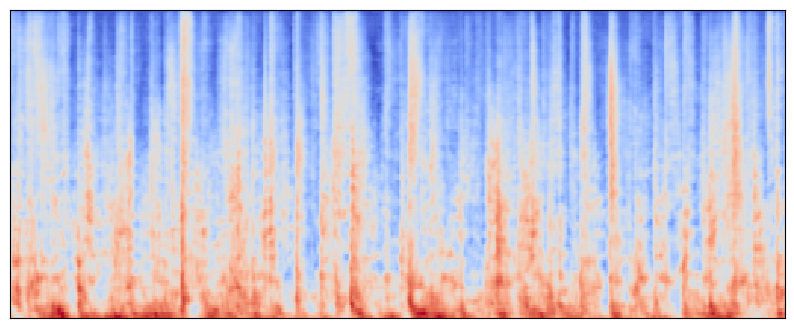

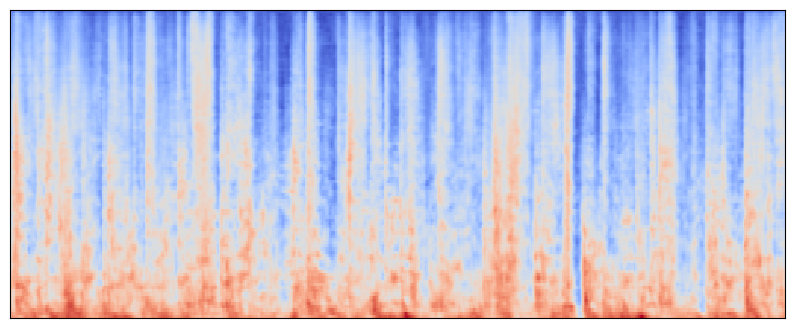

2025-06-11 16:02:58,915 - INFO - Epoch 060: Avg. Loss: 1.12108e-01 Avg. val. Loss: 1.13131e-01 Remaining Time: 00h 40min 35s LR: 1.42528e-04 
2025-06-11 16:03:09,046 - INFO - Epoch 061: Avg. Loss: 9.76824e-02 Avg. val. Loss: 1.14111e-01 Remaining Time: 00h 40min 28s LR: 1.39677e-04 
2025-06-11 16:03:14,783 - INFO - Epoch 062: Avg. Loss: 1.04967e-01 Avg. val. Loss: 1.24752e-01 Remaining Time: 00h 40min 24s LR: 1.36884e-04 
2025-06-11 16:03:20,373 - INFO - Epoch 063: Avg. Loss: 1.01243e-01 Avg. val. Loss: 1.07214e-01 Remaining Time: 00h 40min 18s LR: 1.34146e-04 
2025-06-11 16:03:25,951 - INFO - Epoch 064: Avg. Loss: 1.10863e-01 Avg. val. Loss: 1.22220e-01 Remaining Time: 00h 40min 13s LR: 1.31463e-04 
2025-06-11 16:03:31,298 - INFO - Epoch 065: Avg. Loss: 1.03091e-01 Avg. val. Loss: 9.92443e-02 Remaining Time: 00h 40min 06s LR: 1.28834e-04 
2025-06-11 16:03:36,861 - INFO - Epoch 066: Avg. Loss: 1.04243e-01 Avg. val. Loss: 9.91207e-02 Remaining Time: 00h 40min 01s LR: 1.26257e-04 
2025-0

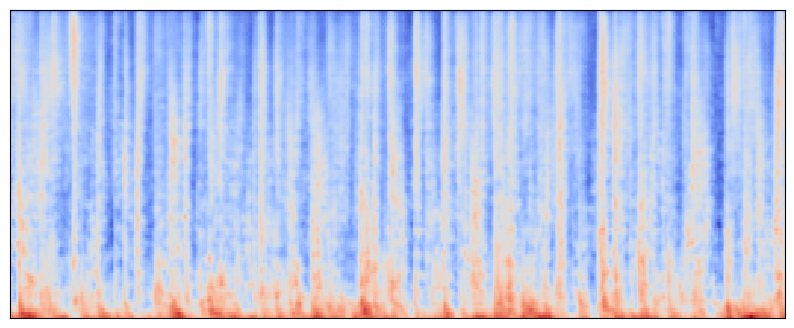

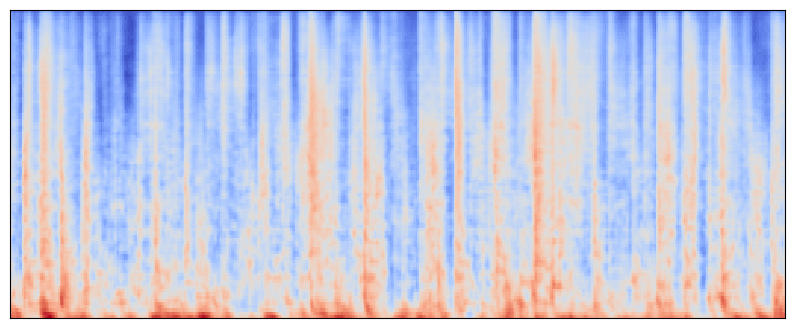

2025-06-11 16:04:59,399 - INFO - Epoch 080: Avg. Loss: 1.04231e-01 Avg. val. Loss: 1.04458e-01 Remaining Time: 00h 38min 45s LR: 9.51528e-05 
2025-06-11 16:05:09,524 - INFO - Epoch 081: Avg. Loss: 1.01408e-01 Avg. val. Loss: 8.71440e-02 Remaining Time: 00h 38min 40s LR: 9.32497e-05 
2025-06-11 16:05:14,931 - INFO - Epoch 082: Avg. Loss: 1.04790e-01 Avg. val. Loss: 1.16870e-01 Remaining Time: 00h 38min 33s LR: 9.13847e-05 
2025-06-11 16:05:20,586 - INFO - Epoch 083: Avg. Loss: 1.02545e-01 Avg. val. Loss: 9.26929e-02 Remaining Time: 00h 38min 28s LR: 8.95571e-05 
2025-06-11 16:05:26,070 - INFO - Epoch 084: Avg. Loss: 1.09334e-01 Avg. val. Loss: 9.23740e-02 Remaining Time: 00h 38min 23s LR: 8.77659e-05 
2025-06-11 16:05:31,449 - INFO - Epoch 085: Avg. Loss: 9.95538e-02 Avg. val. Loss: 1.18723e-01 Remaining Time: 00h 38min 16s LR: 8.60106e-05 
2025-06-11 16:05:37,086 - INFO - Epoch 086: Avg. Loss: 1.08760e-01 Avg. val. Loss: 1.03624e-01 Remaining Time: 00h 38min 11s LR: 8.42904e-05 
2025-0

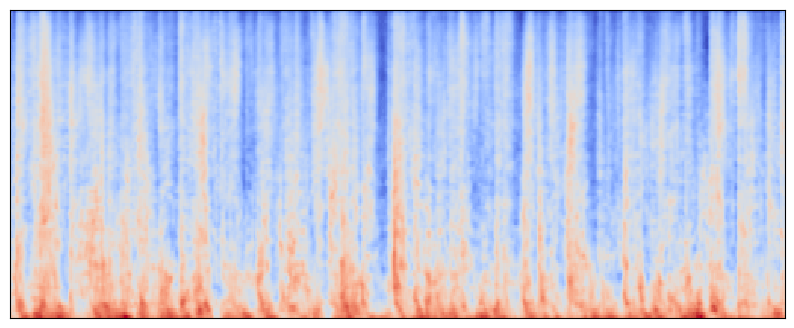

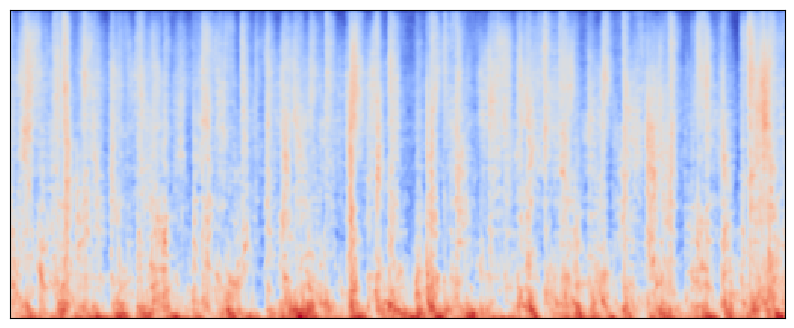

2025-06-11 16:06:59,765 - INFO - Epoch 100: Avg. Loss: 1.04812e-01 Avg. val. Loss: 1.15059e-01 Remaining Time: 00h 36min 57s LR: 6.35248e-05 
2025-06-11 16:07:09,475 - INFO - Epoch 101: Avg. Loss: 1.04023e-01 Avg. val. Loss: 1.40927e-01 Remaining Time: 00h 36min 51s LR: 6.22543e-05 
2025-06-11 16:07:14,996 - INFO - Epoch 102: Avg. Loss: 9.80696e-02 Avg. val. Loss: 8.96517e-02 Remaining Time: 00h 36min 45s LR: 6.10092e-05 
2025-06-11 16:07:20,454 - INFO - Epoch 103: Avg. Loss: 9.75259e-02 Avg. val. Loss: 1.49605e-01 Remaining Time: 00h 36min 39s LR: 5.97890e-05 
2025-06-11 16:07:25,760 - INFO - Epoch 104: Avg. Loss: 1.02125e-01 Avg. val. Loss: 1.30122e-01 Remaining Time: 00h 36min 33s LR: 5.85932e-05 
2025-06-11 16:07:31,284 - INFO - Epoch 105: Avg. Loss: 9.87060e-02 Avg. val. Loss: 9.91416e-02 Remaining Time: 00h 36min 27s LR: 5.74214e-05 
2025-06-11 16:07:36,977 - INFO - Epoch 106: Avg. Loss: 1.01446e-01 Avg. val. Loss: 1.13783e-01 Remaining Time: 00h 36min 22s LR: 5.62729e-05 
2025-0

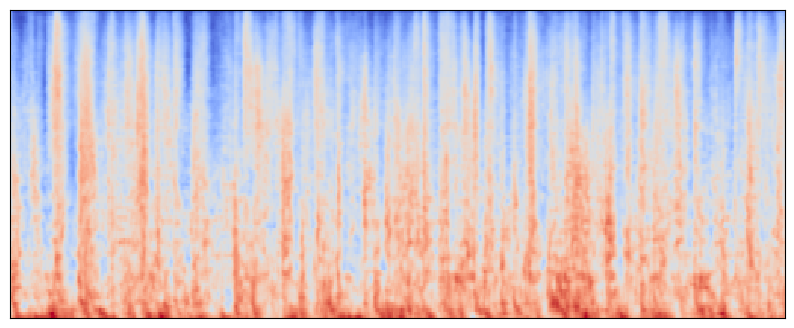

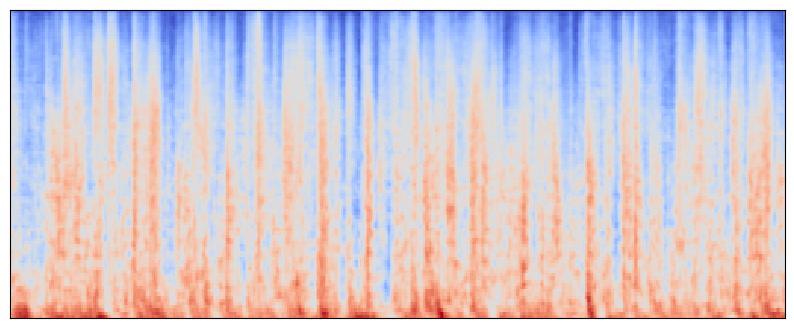

2025-06-11 16:09:00,296 - INFO - Epoch 120: Avg. Loss: 1.06555e-01 Avg. val. Loss: 1.46286e-01 Remaining Time: 00h 35min 09s LR: 4.24096e-05 
2025-06-11 16:09:10,638 - INFO - Epoch 121: Avg. Loss: 1.10080e-01 Avg. val. Loss: 1.19405e-01 Remaining Time: 00h 35min 03s LR: 4.15614e-05 
2025-06-11 16:09:16,000 - INFO - Epoch 122: Avg. Loss: 1.04171e-01 Avg. val. Loss: 1.58244e-01 Remaining Time: 00h 34min 57s LR: 4.07302e-05 
2025-06-11 16:09:21,542 - INFO - Epoch 123: Avg. Loss: 1.01364e-01 Avg. val. Loss: 1.32114e-01 Remaining Time: 00h 34min 52s LR: 3.99156e-05 
2025-06-11 16:09:27,248 - INFO - Epoch 124: Avg. Loss: 1.01249e-01 Avg. val. Loss: 9.85959e-02 Remaining Time: 00h 34min 47s LR: 3.91173e-05 
2025-06-11 16:09:32,542 - INFO - Epoch 125: Avg. Loss: 1.03769e-01 Avg. val. Loss: 8.86751e-02 Remaining Time: 00h 34min 40s LR: 3.83350e-05 
2025-06-11 16:09:38,084 - INFO - Epoch 126: Avg. Loss: 1.03976e-01 Avg. val. Loss: 9.59046e-02 Remaining Time: 00h 34min 35s LR: 3.75683e-05 
2025-0

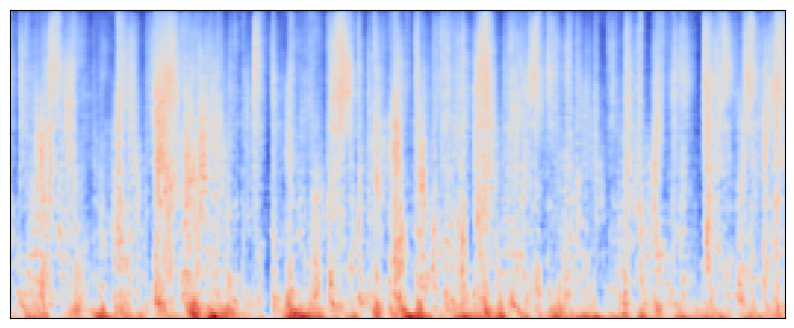

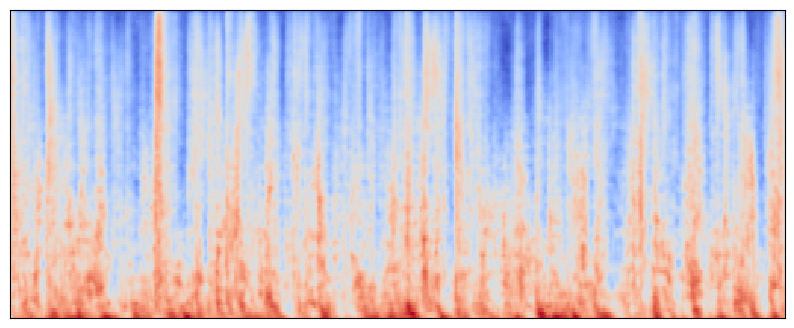

2025-06-11 16:11:02,133 - INFO - Epoch 140: Avg. Loss: 1.11653e-01 Avg. val. Loss: 1.17242e-01 Remaining Time: 00h 33min 21s LR: 2.83130e-05 
2025-06-11 16:11:12,437 - INFO - Epoch 141: Avg. Loss: 1.00612e-01 Avg. val. Loss: 1.11622e-01 Remaining Time: 00h 33min 16s LR: 2.77468e-05 
2025-06-11 16:11:17,932 - INFO - Epoch 142: Avg. Loss: 1.06412e-01 Avg. val. Loss: 8.44128e-02 Remaining Time: 00h 33min 10s LR: 2.71918e-05 
2025-06-11 16:11:23,263 - INFO - Epoch 143: Avg. Loss: 1.04448e-01 Avg. val. Loss: 1.01855e-01 Remaining Time: 00h 33min 04s LR: 2.66480e-05 
2025-06-11 16:11:28,827 - INFO - Epoch 144: Avg. Loss: 1.06779e-01 Avg. val. Loss: 8.98945e-02 Remaining Time: 00h 32min 58s LR: 2.61150e-05 
2025-06-11 16:11:34,286 - INFO - Epoch 145: Avg. Loss: 1.00216e-01 Avg. val. Loss: 1.01710e-01 Remaining Time: 00h 32min 52s LR: 2.55927e-05 
2025-06-11 16:11:39,861 - INFO - Epoch 146: Avg. Loss: 9.99906e-02 Avg. val. Loss: 1.00666e-01 Remaining Time: 00h 32min 47s LR: 2.50809e-05 
2025-0

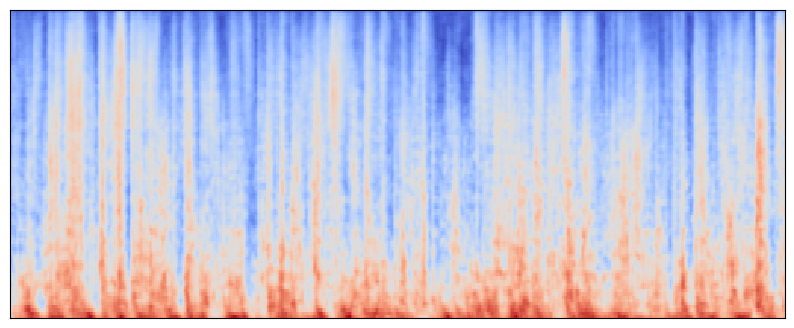

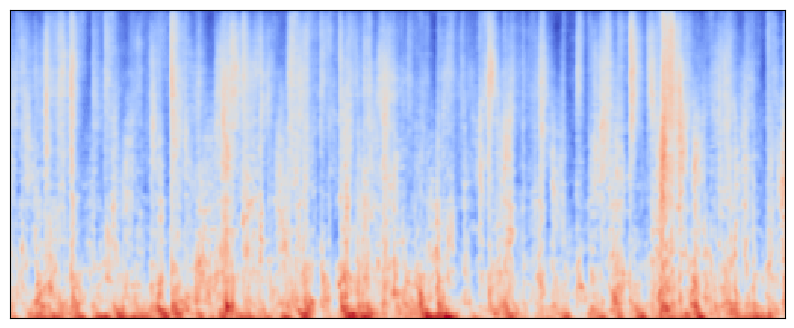

2025-06-11 16:13:02,168 - INFO - Epoch 160: Avg. Loss: 1.09254e-01 Avg. val. Loss: 8.65742e-02 Remaining Time: 00h 31min 29s LR: 1.89020e-05 
2025-06-11 16:13:12,784 - INFO - Epoch 161: Avg. Loss: 1.05025e-01 Avg. val. Loss: 1.15940e-01 Remaining Time: 00h 31min 24s LR: 1.85240e-05 
2025-06-11 16:13:18,084 - INFO - Epoch 162: Avg. Loss: 1.04267e-01 Avg. val. Loss: 9.48393e-02 Remaining Time: 00h 31min 18s LR: 1.81535e-05 
2025-06-11 16:13:23,628 - INFO - Epoch 163: Avg. Loss: 1.04461e-01 Avg. val. Loss: 1.56657e-01 Remaining Time: 00h 31min 12s LR: 1.77904e-05 
2025-06-11 16:13:29,144 - INFO - Epoch 164: Avg. Loss: 1.00265e-01 Avg. val. Loss: 7.39283e-02 Remaining Time: 00h 31min 06s LR: 1.74346e-05 
2025-06-11 16:13:34,616 - INFO - Epoch 165: Avg. Loss: 1.06851e-01 Avg. val. Loss: 9.68883e-02 Remaining Time: 00h 31min 01s LR: 1.70859e-05 
2025-06-11 16:13:40,138 - INFO - Epoch 166: Avg. Loss: 1.10940e-01 Avg. val. Loss: 1.71160e-01 Remaining Time: 00h 30min 55s LR: 1.67442e-05 
2025-0

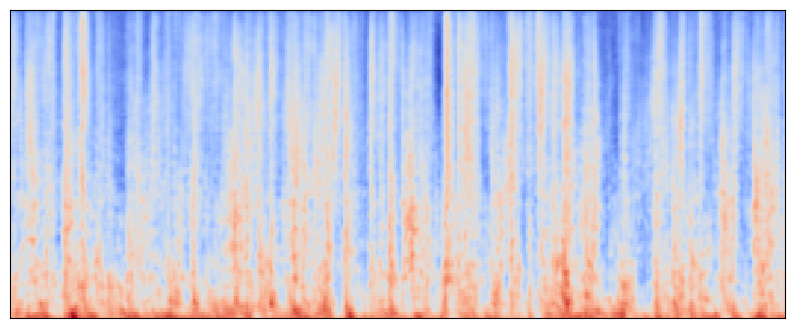

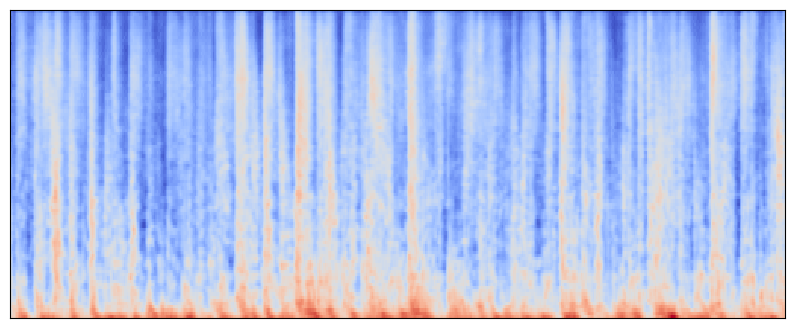

2025-06-11 16:15:02,807 - INFO - Epoch 180: Avg. Loss: 1.03891e-01 Avg. val. Loss: 1.29447e-01 Remaining Time: 00h 29min 38s LR: 1.26191e-05 
2025-06-11 16:15:12,818 - INFO - Epoch 181: Avg. Loss: 1.01632e-01 Avg. val. Loss: 8.82809e-02 Remaining Time: 00h 29min 33s LR: 1.23667e-05 
2025-06-11 16:15:18,276 - INFO - Epoch 182: Avg. Loss: 1.01373e-01 Avg. val. Loss: 1.20840e-01 Remaining Time: 00h 29min 27s LR: 1.21194e-05 
2025-06-11 16:15:23,762 - INFO - Epoch 183: Avg. Loss: 1.01715e-01 Avg. val. Loss: 8.19292e-02 Remaining Time: 00h 29min 22s LR: 1.18770e-05 
2025-06-11 16:15:29,163 - INFO - Epoch 184: Avg. Loss: 9.86248e-02 Avg. val. Loss: 1.39892e-01 Remaining Time: 00h 29min 16s LR: 1.16395e-05 
2025-06-11 16:15:34,683 - INFO - Epoch 185: Avg. Loss: 1.15144e-01 Avg. val. Loss: 8.81414e-02 Remaining Time: 00h 29min 10s LR: 1.14067e-05 
2025-06-11 16:15:40,411 - INFO - Epoch 186: Avg. Loss: 1.03440e-01 Avg. val. Loss: 8.81003e-02 Remaining Time: 00h 29min 05s LR: 1.11786e-05 
2025-0

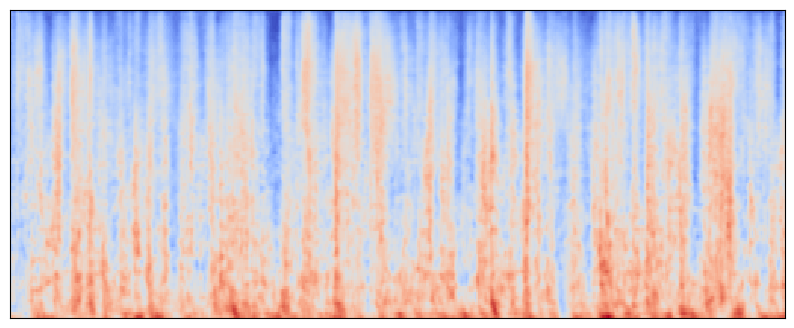

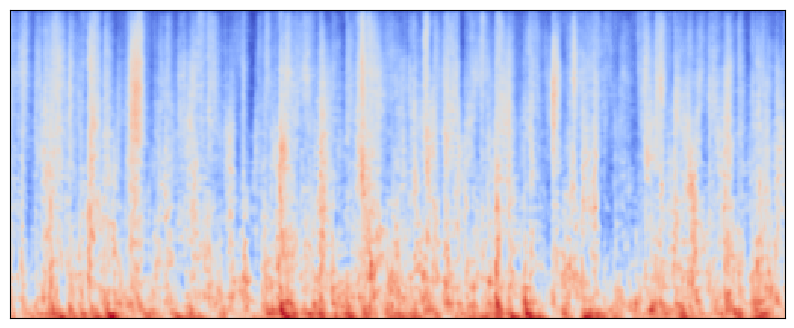

2025-06-11 16:17:02,952 - INFO - Epoch 200: Avg. Loss: 1.06793e-01 Avg. val. Loss: 1.50034e-01 Remaining Time: 00h 27min 48s LR: 8.42463e-06 
2025-06-11 16:17:13,302 - INFO - Epoch 201: Avg. Loss: 1.06155e-01 Avg. val. Loss: 1.12641e-01 Remaining Time: 00h 27min 42s LR: 8.25613e-06 
2025-06-11 16:17:19,035 - INFO - Epoch 202: Avg. Loss: 1.10830e-01 Avg. val. Loss: 1.18710e-01 Remaining Time: 00h 27min 37s LR: 8.09101e-06 
2025-06-11 16:17:24,588 - INFO - Epoch 203: Avg. Loss: 1.12879e-01 Avg. val. Loss: 9.03524e-02 Remaining Time: 00h 27min 31s LR: 7.92919e-06 
2025-06-11 16:17:30,092 - INFO - Epoch 204: Avg. Loss: 1.08863e-01 Avg. val. Loss: 1.48825e-01 Remaining Time: 00h 27min 26s LR: 7.77061e-06 
2025-06-11 16:17:35,585 - INFO - Epoch 205: Avg. Loss: 1.06179e-01 Avg. val. Loss: 1.12221e-01 Remaining Time: 00h 27min 20s LR: 7.61520e-06 
2025-06-11 16:17:41,154 - INFO - Epoch 206: Avg. Loss: 9.88930e-02 Avg. val. Loss: 8.55287e-02 Remaining Time: 00h 27min 14s LR: 7.46289e-06 
2025-0

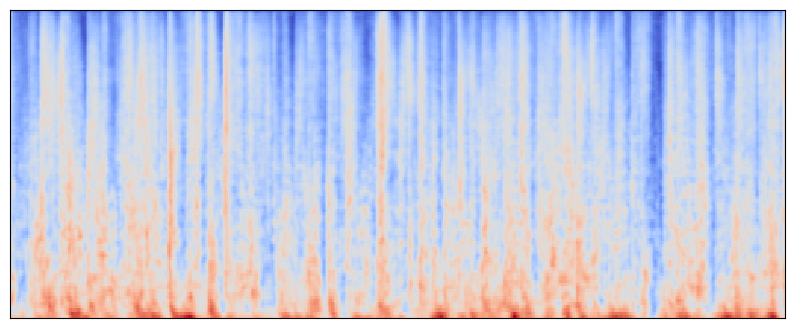

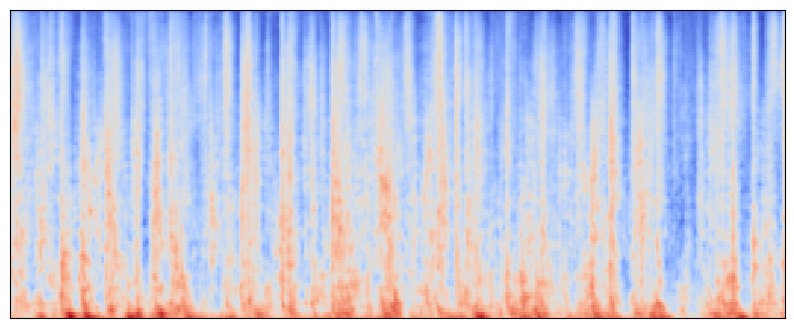

2025-06-11 16:19:03,783 - INFO - Epoch 220: Avg. Loss: 1.07606e-01 Avg. val. Loss: 9.37742e-02 Remaining Time: 00h 25min 57s LR: 5.62435e-06 
2025-06-11 16:19:13,819 - INFO - Epoch 221: Avg. Loss: 1.08547e-01 Avg. val. Loss: 1.35412e-01 Remaining Time: 00h 25min 52s LR: 5.51186e-06 
2025-06-11 16:19:19,390 - INFO - Epoch 222: Avg. Loss: 1.03906e-01 Avg. val. Loss: 9.57729e-02 Remaining Time: 00h 25min 46s LR: 5.40162e-06 
2025-06-11 16:19:24,738 - INFO - Epoch 223: Avg. Loss: 1.08225e-01 Avg. val. Loss: 1.63143e-01 Remaining Time: 00h 25min 41s LR: 5.29359e-06 
2025-06-11 16:19:30,261 - INFO - Epoch 224: Avg. Loss: 1.01299e-01 Avg. val. Loss: 1.21065e-01 Remaining Time: 00h 25min 35s LR: 5.18772e-06 
2025-06-11 16:19:35,902 - INFO - Epoch 225: Avg. Loss: 1.05696e-01 Avg. val. Loss: 1.37406e-01 Remaining Time: 00h 25min 29s LR: 5.08396e-06 
2025-06-11 16:19:41,252 - INFO - Epoch 226: Avg. Loss: 1.06098e-01 Avg. val. Loss: 9.70074e-02 Remaining Time: 00h 25min 24s LR: 4.98229e-06 
2025-0

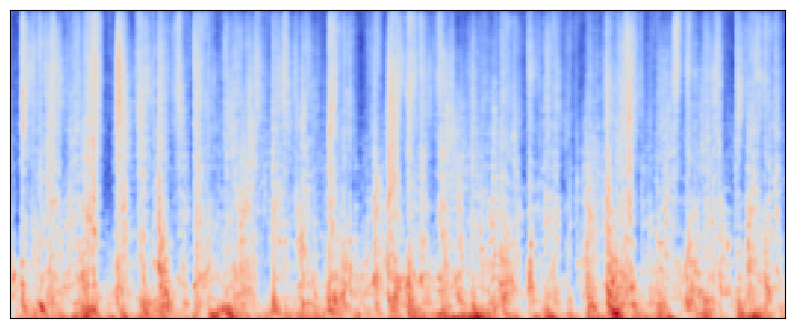

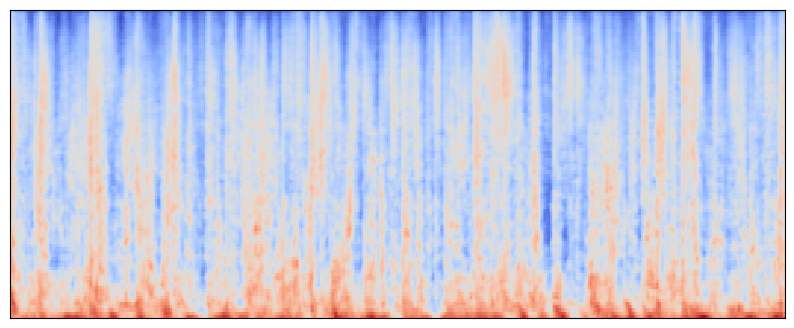

2025-06-11 16:21:04,475 - INFO - Epoch 240: Avg. Loss: 1.07631e-01 Avg. val. Loss: 9.40600e-02 Remaining Time: 00h 24min 06s LR: 3.75486e-06 
2025-06-11 16:21:14,289 - INFO - Epoch 241: Avg. Loss: 1.07713e-01 Avg. val. Loss: 9.80906e-02 Remaining Time: 00h 24min 01s LR: 3.67976e-06 
2025-06-11 16:21:19,813 - INFO - Epoch 242: Avg. Loss: 1.11939e-01 Avg. val. Loss: 1.16087e-01 Remaining Time: 00h 23min 55s LR: 3.60617e-06 
2025-06-11 16:21:25,366 - INFO - Epoch 243: Avg. Loss: 9.62713e-02 Avg. val. Loss: 8.63781e-02 Remaining Time: 00h 23min 50s LR: 3.53404e-06 
2025-06-11 16:21:30,746 - INFO - Epoch 244: Avg. Loss: 1.04889e-01 Avg. val. Loss: 1.23575e-01 Remaining Time: 00h 23min 44s LR: 3.46336e-06 
2025-06-11 16:21:36,643 - INFO - Epoch 245: Avg. Loss: 1.00470e-01 Avg. val. Loss: 9.64173e-02 Remaining Time: 00h 23min 39s LR: 3.39410e-06 
2025-06-11 16:21:41,924 - INFO - Epoch 246: Avg. Loss: 1.06481e-01 Avg. val. Loss: 8.75427e-02 Remaining Time: 00h 23min 33s LR: 3.32621e-06 
2025-0

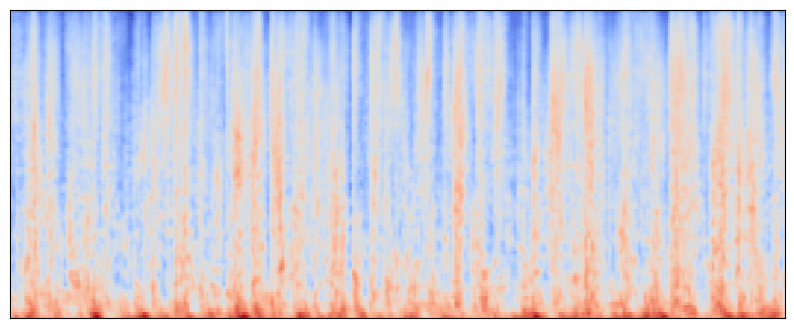

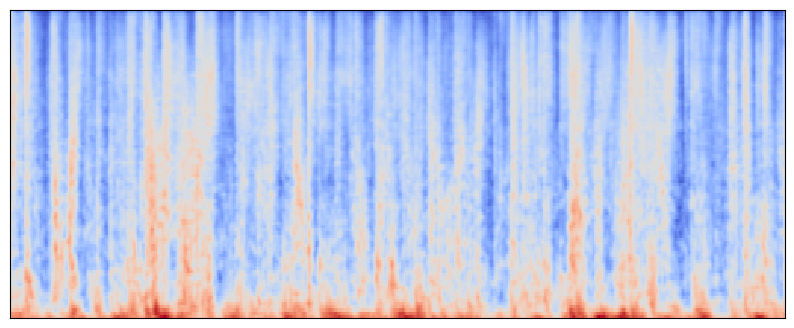

2025-06-11 16:23:04,449 - INFO - Epoch 260: Avg. Loss: 1.00720e-01 Avg. val. Loss: 1.04857e-01 Remaining Time: 00h 22min 15s LR: 2.50677e-06 
2025-06-11 16:23:14,827 - INFO - Epoch 261: Avg. Loss: 1.05052e-01 Avg. val. Loss: 9.77702e-02 Remaining Time: 00h 22min 09s LR: 2.45664e-06 
2025-06-11 16:23:20,279 - INFO - Epoch 262: Avg. Loss: 1.06740e-01 Avg. val. Loss: 8.48994e-02 Remaining Time: 00h 22min 04s LR: 2.40751e-06 
2025-06-11 16:23:25,764 - INFO - Epoch 263: Avg. Loss: 1.12948e-01 Avg. val. Loss: 1.08788e-01 Remaining Time: 00h 21min 58s LR: 2.35936e-06 
2025-06-11 16:23:31,458 - INFO - Epoch 264: Avg. Loss: 1.00015e-01 Avg. val. Loss: 1.00966e-01 Remaining Time: 00h 21min 53s LR: 2.31217e-06 
2025-06-11 16:23:37,452 - INFO - Epoch 265: Avg. Loss: 1.06510e-01 Avg. val. Loss: 1.06946e-01 Remaining Time: 00h 21min 47s LR: 2.26593e-06 
2025-06-11 16:23:42,969 - INFO - Epoch 266: Avg. Loss: 1.11476e-01 Avg. val. Loss: 1.32526e-01 Remaining Time: 00h 21min 42s LR: 2.22061e-06 
2025-0

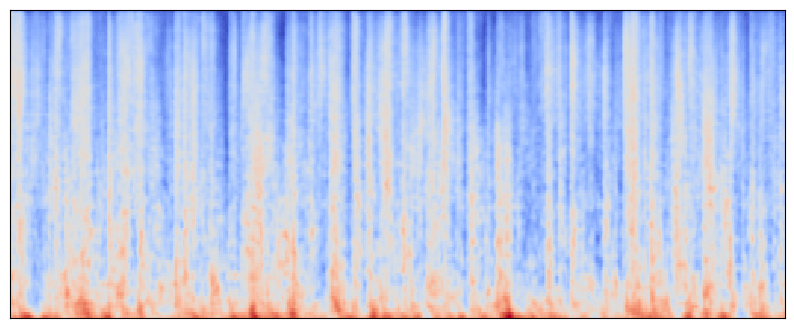

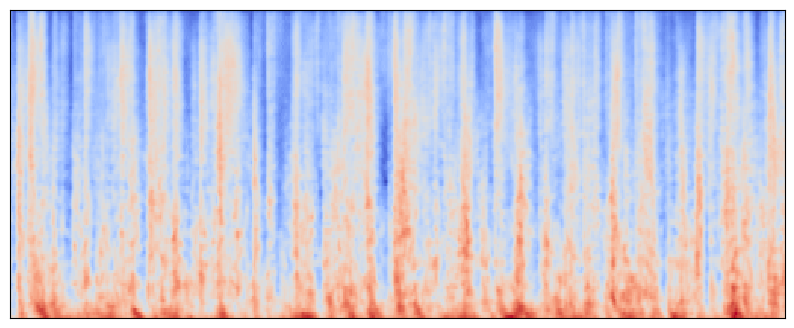

2025-06-11 16:25:05,334 - INFO - Epoch 280: Avg. Loss: 9.99281e-02 Avg. val. Loss: 1.21982e-01 Remaining Time: 00h 20min 24s LR: 1.67354e-06 
2025-06-11 16:25:15,612 - INFO - Epoch 281: Avg. Loss: 1.00064e-01 Avg. val. Loss: 1.03746e-01 Remaining Time: 00h 20min 18s LR: 1.64007e-06 
2025-06-11 16:25:20,981 - INFO - Epoch 282: Avg. Loss: 1.10395e-01 Avg. val. Loss: 9.30379e-02 Remaining Time: 00h 20min 13s LR: 1.60727e-06 
2025-06-11 16:25:26,523 - INFO - Epoch 283: Avg. Loss: 1.15291e-01 Avg. val. Loss: 1.24232e-01 Remaining Time: 00h 20min 07s LR: 1.57512e-06 
2025-06-11 16:25:32,060 - INFO - Epoch 284: Avg. Loss: 1.00794e-01 Avg. val. Loss: 1.36615e-01 Remaining Time: 00h 20min 01s LR: 1.54362e-06 
2025-06-11 16:25:37,513 - INFO - Epoch 285: Avg. Loss: 1.07827e-01 Avg. val. Loss: 1.28719e-01 Remaining Time: 00h 19min 56s LR: 1.51275e-06 
2025-06-11 16:25:42,993 - INFO - Epoch 286: Avg. Loss: 1.04797e-01 Avg. val. Loss: 1.31201e-01 Remaining Time: 00h 19min 50s LR: 1.48249e-06 
2025-0

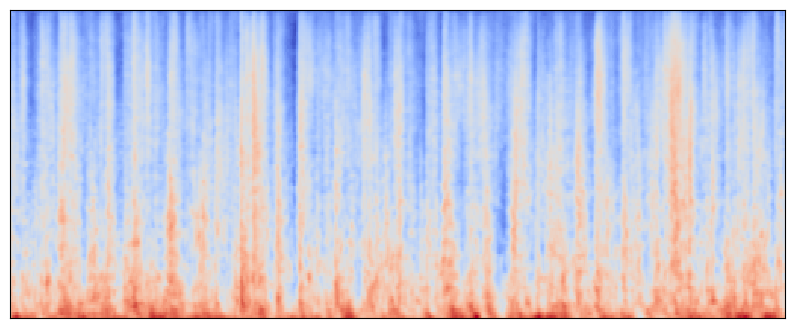

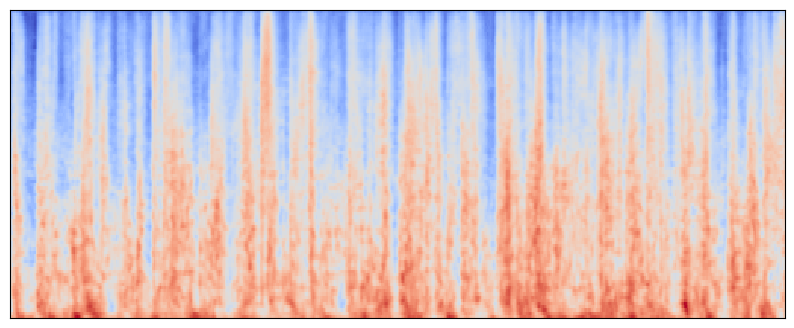

2025-06-11 16:27:05,750 - INFO - Epoch 300: Avg. Loss: 9.89333e-02 Avg. val. Loss: 1.11822e-01 Remaining Time: 00h 18min 32s LR: 1.11727e-06 
2025-06-11 16:27:15,897 - INFO - Epoch 301: Avg. Loss: 1.01264e-01 Avg. val. Loss: 9.46439e-02 Remaining Time: 00h 18min 27s LR: 1.09492e-06 
2025-06-11 16:27:21,516 - INFO - Epoch 302: Avg. Loss: 9.76836e-02 Avg. val. Loss: 1.02612e-01 Remaining Time: 00h 18min 21s LR: 1.07303e-06 
2025-06-11 16:27:26,913 - INFO - Epoch 303: Avg. Loss: 1.04030e-01 Avg. val. Loss: 8.53476e-02 Remaining Time: 00h 18min 16s LR: 1.05157e-06 
2025-06-11 16:27:32,404 - INFO - Epoch 304: Avg. Loss: 1.01602e-01 Avg. val. Loss: 1.24129e-01 Remaining Time: 00h 18min 10s LR: 1.03053e-06 
2025-06-11 16:27:38,291 - INFO - Epoch 305: Avg. Loss: 1.08915e-01 Avg. val. Loss: 1.24673e-01 Remaining Time: 00h 18min 05s LR: 1.00992e-06 
2025-06-11 16:27:43,858 - INFO - Epoch 306: Avg. Loss: 1.03859e-01 Avg. val. Loss: 1.29321e-01 Remaining Time: 00h 17min 59s LR: 9.89725e-07 
2025-0

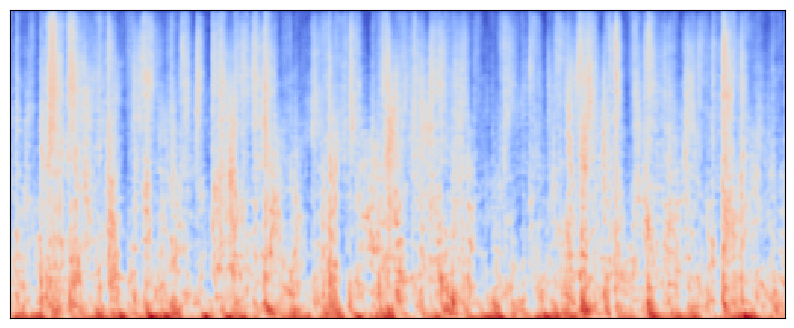

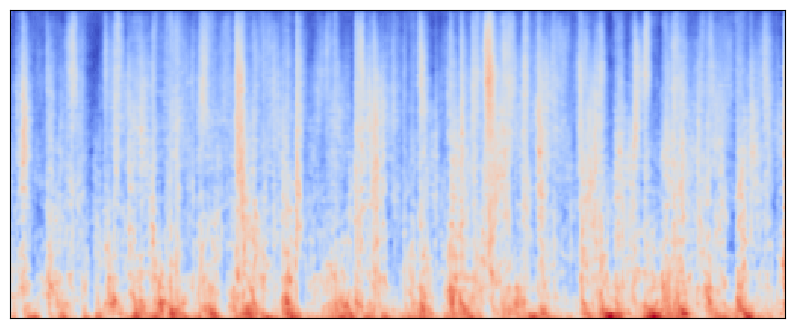

2025-06-11 16:29:06,552 - INFO - Epoch 320: Avg. Loss: 1.02844e-01 Avg. val. Loss: 1.10452e-01 Remaining Time: 00h 16min 41s LR: 7.45899e-07 
2025-06-11 16:29:16,521 - INFO - Epoch 321: Avg. Loss: 1.06794e-01 Avg. val. Loss: 1.30583e-01 Remaining Time: 00h 16min 36s LR: 7.30981e-07 
2025-06-11 16:29:22,057 - INFO - Epoch 322: Avg. Loss: 1.02714e-01 Avg. val. Loss: 8.24020e-02 Remaining Time: 00h 16min 30s LR: 7.16361e-07 
2025-06-11 16:29:27,428 - INFO - Epoch 323: Avg. Loss: 1.00493e-01 Avg. val. Loss: 1.09753e-01 Remaining Time: 00h 16min 25s LR: 7.02034e-07 
2025-06-11 16:29:32,944 - INFO - Epoch 324: Avg. Loss: 1.01124e-01 Avg. val. Loss: 8.83085e-02 Remaining Time: 00h 16min 19s LR: 6.87993e-07 
2025-06-11 16:29:38,638 - INFO - Epoch 325: Avg. Loss: 1.03256e-01 Avg. val. Loss: 8.83973e-02 Remaining Time: 00h 16min 14s LR: 6.74233e-07 
2025-06-11 16:29:44,146 - INFO - Epoch 326: Avg. Loss: 1.07235e-01 Avg. val. Loss: 1.81395e-01 Remaining Time: 00h 16min 08s LR: 6.60749e-07 
2025-0

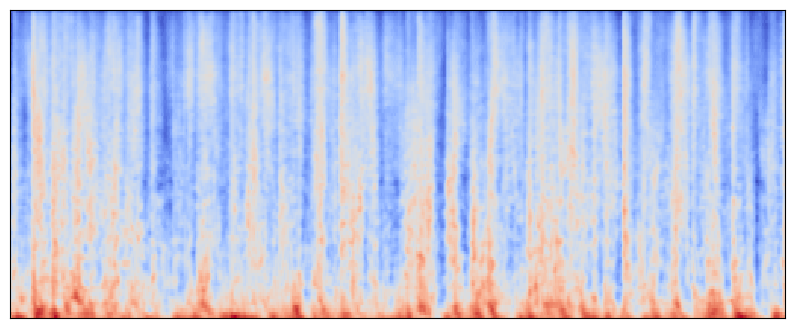

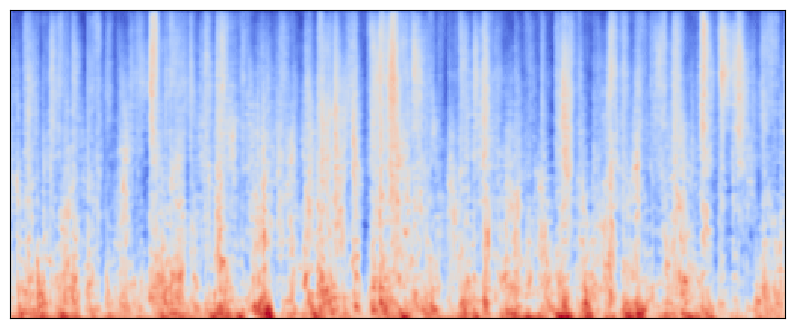

2025-06-11 16:31:07,551 - INFO - Epoch 340: Avg. Loss: 1.09267e-01 Avg. val. Loss: 1.00928e-01 Remaining Time: 00h 14min 51s LR: 4.97968e-07 
2025-06-11 16:31:17,501 - INFO - Epoch 341: Avg. Loss: 1.03488e-01 Avg. val. Loss: 1.00887e-01 Remaining Time: 00h 14min 45s LR: 4.88008e-07 
2025-06-11 16:31:23,220 - INFO - Epoch 342: Avg. Loss: 1.02108e-01 Avg. val. Loss: 1.09692e-01 Remaining Time: 00h 14min 40s LR: 4.78248e-07 
2025-06-11 16:31:28,721 - INFO - Epoch 343: Avg. Loss: 1.04278e-01 Avg. val. Loss: 9.32265e-02 Remaining Time: 00h 14min 34s LR: 4.68683e-07 
2025-06-11 16:31:34,198 - INFO - Epoch 344: Avg. Loss: 1.01826e-01 Avg. val. Loss: 9.61204e-02 Remaining Time: 00h 14min 28s LR: 4.59310e-07 
2025-06-11 16:31:39,785 - INFO - Epoch 345: Avg. Loss: 1.02769e-01 Avg. val. Loss: 9.63197e-02 Remaining Time: 00h 14min 23s LR: 4.50123e-07 
2025-06-11 16:31:45,348 - INFO - Epoch 346: Avg. Loss: 1.04016e-01 Avg. val. Loss: 9.48296e-02 Remaining Time: 00h 14min 17s LR: 4.41121e-07 
2025-0

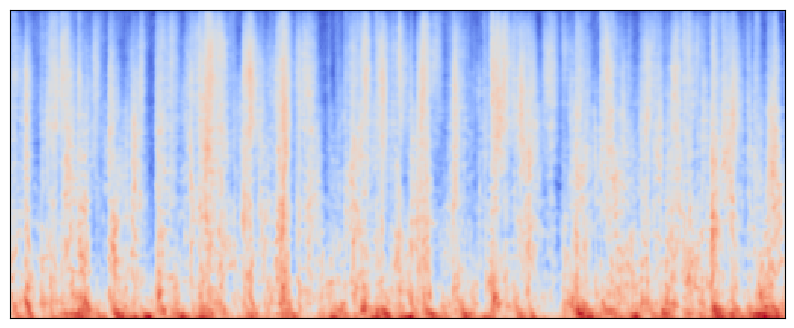

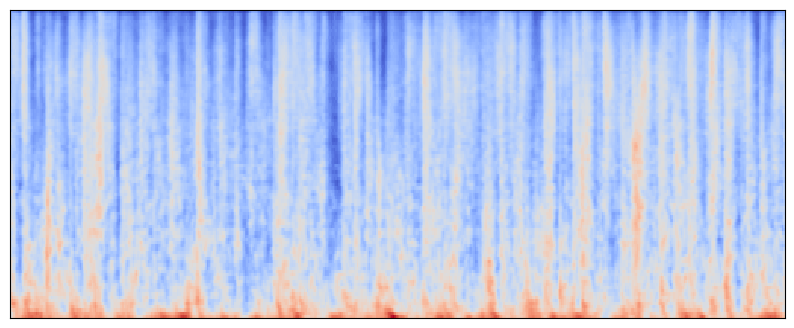

2025-06-11 16:33:08,446 - INFO - Epoch 360: Avg. Loss: 1.08254e-01 Avg. val. Loss: 9.79910e-02 Remaining Time: 00h 12min 59s LR: 3.32447e-07 
2025-06-11 16:33:18,688 - INFO - Epoch 361: Avg. Loss: 1.01805e-01 Avg. val. Loss: 1.37247e-01 Remaining Time: 00h 12min 54s LR: 3.25798e-07 
2025-06-11 16:33:24,287 - INFO - Epoch 362: Avg. Loss: 9.99524e-02 Avg. val. Loss: 8.39099e-02 Remaining Time: 00h 12min 48s LR: 3.19282e-07 
2025-06-11 16:33:29,834 - INFO - Epoch 363: Avg. Loss: 1.06168e-01 Avg. val. Loss: 1.24647e-01 Remaining Time: 00h 12min 43s LR: 3.12897e-07 
2025-06-11 16:33:35,322 - INFO - Epoch 364: Avg. Loss: 1.06731e-01 Avg. val. Loss: 1.07917e-01 Remaining Time: 00h 12min 37s LR: 3.06639e-07 
2025-06-11 16:33:40,704 - INFO - Epoch 365: Avg. Loss: 9.97554e-02 Avg. val. Loss: 1.22129e-01 Remaining Time: 00h 12min 31s LR: 3.00506e-07 
2025-06-11 16:33:46,317 - INFO - Epoch 366: Avg. Loss: 1.03482e-01 Avg. val. Loss: 9.75564e-02 Remaining Time: 00h 12min 26s LR: 2.94496e-07 
2025-0

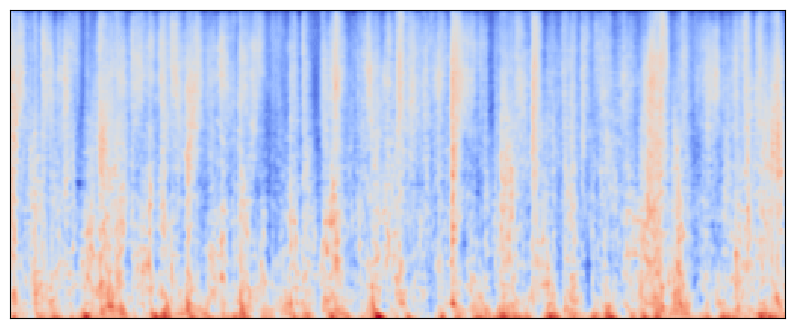

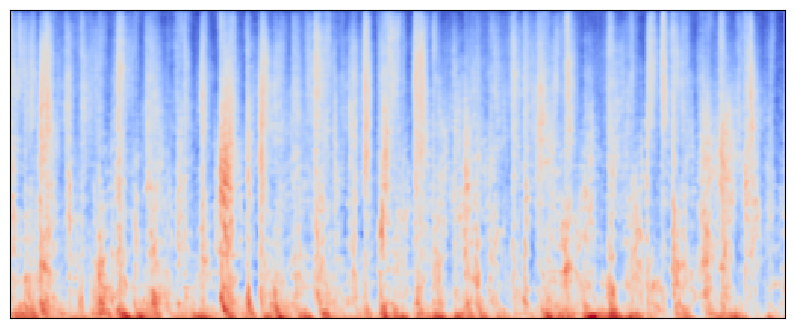

2025-06-11 16:35:09,161 - INFO - Epoch 380: Avg. Loss: 1.16536e-01 Avg. val. Loss: 1.32399e-01 Remaining Time: 00h 11min 08s LR: 2.21944e-07 
2025-06-11 16:35:19,322 - INFO - Epoch 381: Avg. Loss: 1.04239e-01 Avg. val. Loss: 9.81561e-02 Remaining Time: 00h 11min 03s LR: 2.17506e-07 
2025-06-11 16:35:24,754 - INFO - Epoch 382: Avg. Loss: 1.10322e-01 Avg. val. Loss: 1.25310e-01 Remaining Time: 00h 10min 57s LR: 2.13155e-07 
2025-06-11 16:35:30,162 - INFO - Epoch 383: Avg. Loss: 1.00987e-01 Avg. val. Loss: 1.04846e-01 Remaining Time: 00h 10min 51s LR: 2.08892e-07 
2025-06-11 16:35:35,868 - INFO - Epoch 384: Avg. Loss: 1.10109e-01 Avg. val. Loss: 1.12911e-01 Remaining Time: 00h 10min 46s LR: 2.04714e-07 
2025-06-11 16:35:41,324 - INFO - Epoch 385: Avg. Loss: 9.92259e-02 Avg. val. Loss: 9.13753e-02 Remaining Time: 00h 10min 40s LR: 2.00620e-07 
2025-06-11 16:35:46,753 - INFO - Epoch 386: Avg. Loss: 1.03142e-01 Avg. val. Loss: 1.18141e-01 Remaining Time: 00h 10min 35s LR: 1.96608e-07 
2025-0

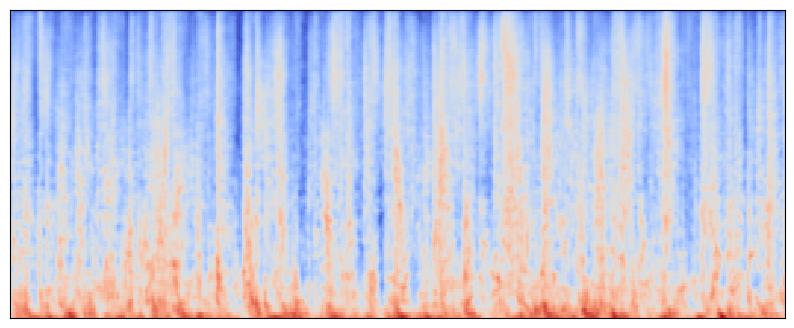

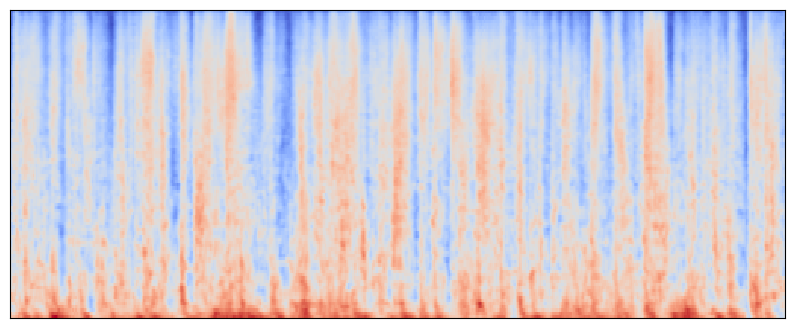

2025-06-11 16:37:09,574 - INFO - Epoch 400: Avg. Loss: 1.12991e-01 Avg. val. Loss: 1.38260e-01 Remaining Time: 00h 09min 17s LR: 1.48172e-07 
2025-06-11 16:37:19,318 - INFO - Epoch 401: Avg. Loss: 1.08985e-01 Avg. val. Loss: 7.84881e-02 Remaining Time: 00h 09min 11s LR: 1.45208e-07 
2025-06-11 16:37:25,084 - INFO - Epoch 402: Avg. Loss: 1.03830e-01 Avg. val. Loss: 1.17506e-01 Remaining Time: 00h 09min 05s LR: 1.42304e-07 
2025-06-11 16:37:30,750 - INFO - Epoch 403: Avg. Loss: 9.82397e-02 Avg. val. Loss: 1.15352e-01 Remaining Time: 00h 09min 00s LR: 1.39458e-07 
2025-06-11 16:37:36,288 - INFO - Epoch 404: Avg. Loss: 1.07380e-01 Avg. val. Loss: 1.24443e-01 Remaining Time: 00h 08min 54s LR: 1.36669e-07 
2025-06-11 16:37:41,802 - INFO - Epoch 405: Avg. Loss: 1.04303e-01 Avg. val. Loss: 1.27548e-01 Remaining Time: 00h 08min 49s LR: 1.33936e-07 
2025-06-11 16:37:47,311 - INFO - Epoch 406: Avg. Loss: 1.01777e-01 Avg. val. Loss: 1.06273e-01 Remaining Time: 00h 08min 43s LR: 1.31257e-07 
2025-0

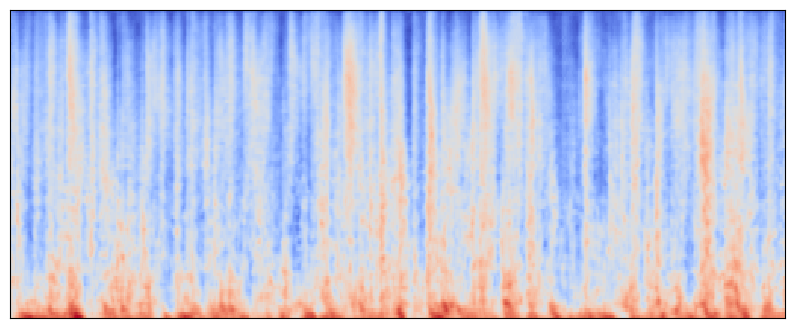

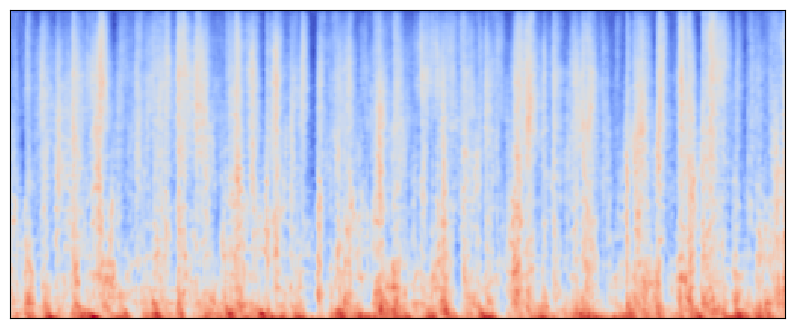

2025-06-11 16:39:10,527 - INFO - Epoch 420: Avg. Loss: 1.02497e-01 Avg. val. Loss: 1.27105e-01 Remaining Time: 00h 07min 25s LR: 9.89207e-08 
2025-06-11 16:39:20,638 - INFO - Epoch 421: Avg. Loss: 1.17434e-01 Avg. val. Loss: 9.96989e-02 Remaining Time: 00h 07min 20s LR: 9.69423e-08 
2025-06-11 16:39:26,151 - INFO - Epoch 422: Avg. Loss: 1.01026e-01 Avg. val. Loss: 9.05349e-02 Remaining Time: 00h 07min 14s LR: 9.50035e-08 
2025-06-11 16:39:31,469 - INFO - Epoch 423: Avg. Loss: 1.06094e-01 Avg. val. Loss: 1.06573e-01 Remaining Time: 00h 07min 09s LR: 9.31034e-08 
2025-06-11 16:39:37,312 - INFO - Epoch 424: Avg. Loss: 1.01787e-01 Avg. val. Loss: 9.59170e-02 Remaining Time: 00h 07min 03s LR: 9.12413e-08 
2025-06-11 16:39:42,909 - INFO - Epoch 425: Avg. Loss: 1.09222e-01 Avg. val. Loss: 1.04239e-01 Remaining Time: 00h 06min 57s LR: 8.94165e-08 
2025-06-11 16:39:48,443 - INFO - Epoch 426: Avg. Loss: 1.01239e-01 Avg. val. Loss: 8.56135e-02 Remaining Time: 00h 06min 52s LR: 8.76282e-08 
2025-0

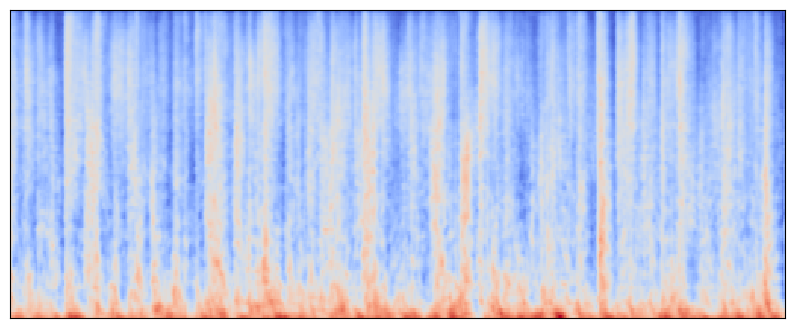

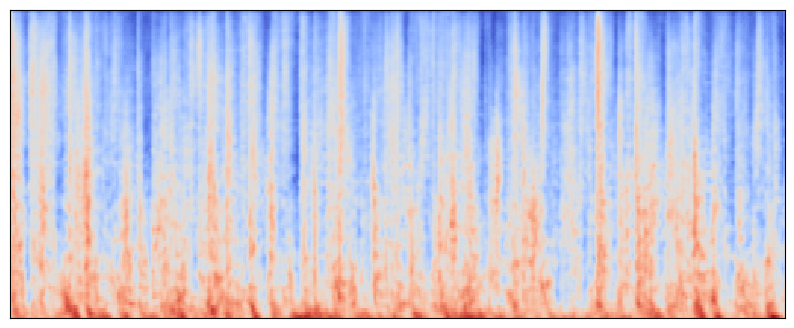

2025-06-11 16:41:10,188 - INFO - Epoch 440: Avg. Loss: 1.07997e-01 Avg. val. Loss: 1.03022e-01 Remaining Time: 00h 05min 34s LR: 6.60403e-08 
2025-06-11 16:41:20,206 - INFO - Epoch 441: Avg. Loss: 1.12987e-01 Avg. val. Loss: 1.26148e-01 Remaining Time: 00h 05min 28s LR: 6.47195e-08 
2025-06-11 16:41:26,064 - INFO - Epoch 442: Avg. Loss: 1.06745e-01 Avg. val. Loss: 9.85606e-02 Remaining Time: 00h 05min 23s LR: 6.34251e-08 
2025-06-11 16:41:31,525 - INFO - Epoch 443: Avg. Loss: 1.09259e-01 Avg. val. Loss: 1.12963e-01 Remaining Time: 00h 05min 17s LR: 6.21566e-08 
2025-06-11 16:41:36,823 - INFO - Epoch 444: Avg. Loss: 1.07881e-01 Avg. val. Loss: 1.26994e-01 Remaining Time: 00h 05min 11s LR: 6.09134e-08 
2025-06-11 16:41:42,482 - INFO - Epoch 445: Avg. Loss: 9.77473e-02 Avg. val. Loss: 7.79134e-02 Remaining Time: 00h 05min 06s LR: 5.96952e-08 
2025-06-11 16:41:47,950 - INFO - Epoch 446: Avg. Loss: 9.69691e-02 Avg. val. Loss: 1.21462e-01 Remaining Time: 00h 05min 00s LR: 5.85013e-08 
2025-0

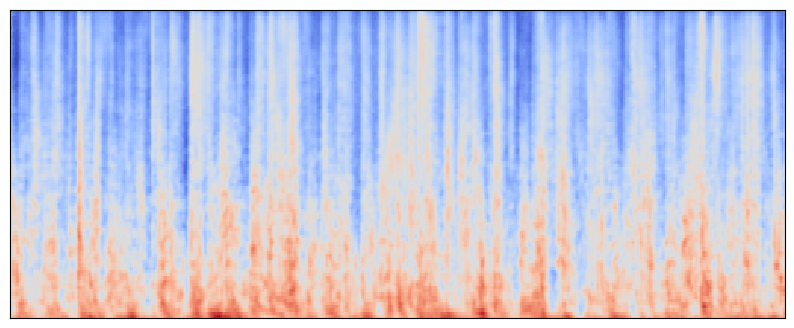

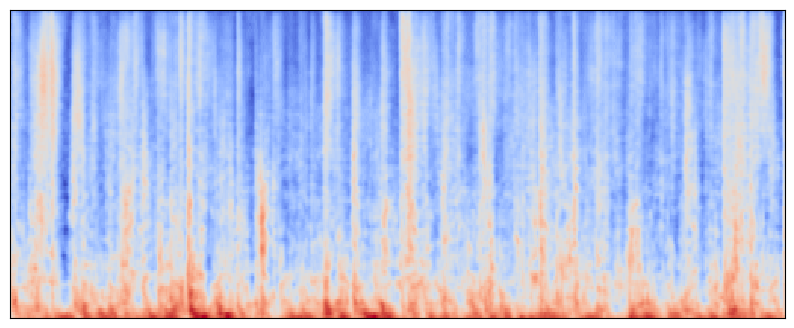

2025-06-11 16:43:11,276 - INFO - Epoch 460: Avg. Loss: 9.82474e-02 Avg. val. Loss: 8.13509e-02 Remaining Time: 00h 03min 42s LR: 4.40890e-08 
2025-06-11 16:43:20,977 - INFO - Epoch 461: Avg. Loss: 1.04951e-01 Avg. val. Loss: 1.19236e-01 Remaining Time: 00h 03min 37s LR: 4.32072e-08 
2025-06-11 16:43:26,860 - INFO - Epoch 462: Avg. Loss: 1.04449e-01 Avg. val. Loss: 1.05406e-01 Remaining Time: 00h 03min 31s LR: 4.23431e-08 
2025-06-11 16:43:32,558 - INFO - Epoch 463: Avg. Loss: 1.03686e-01 Avg. val. Loss: 9.63390e-02 Remaining Time: 00h 03min 26s LR: 4.14962e-08 
2025-06-11 16:43:38,171 - INFO - Epoch 464: Avg. Loss: 1.05427e-01 Avg. val. Loss: 9.07323e-02 Remaining Time: 00h 03min 20s LR: 4.06663e-08 
2025-06-11 16:43:43,465 - INFO - Epoch 465: Avg. Loss: 1.09798e-01 Avg. val. Loss: 8.94534e-02 Remaining Time: 00h 03min 15s LR: 3.98530e-08 
2025-06-11 16:43:48,990 - INFO - Epoch 466: Avg. Loss: 1.02696e-01 Avg. val. Loss: 1.12835e-01 Remaining Time: 00h 03min 09s LR: 3.90559e-08 
2025-0

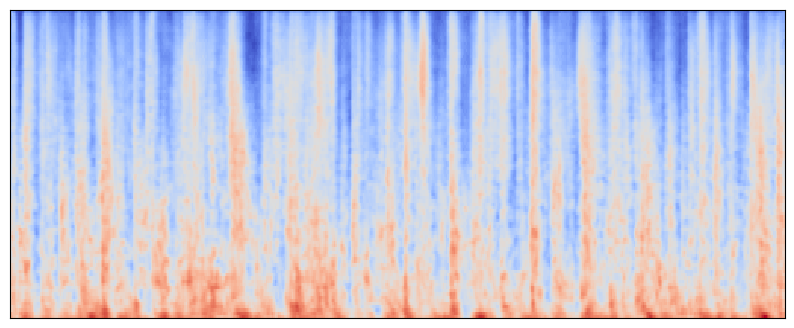

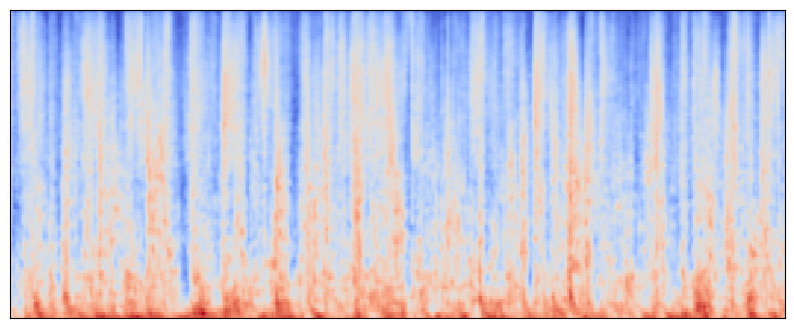

2025-06-11 16:45:11,616 - INFO - Epoch 480: Avg. Loss: 1.02750e-01 Avg. val. Loss: 9.18822e-02 Remaining Time: 00h 01min 51s LR: 2.94342e-08 
2025-06-11 16:45:21,733 - INFO - Epoch 481: Avg. Loss: 1.08773e-01 Avg. val. Loss: 1.23875e-01 Remaining Time: 00h 01min 45s LR: 2.88455e-08 
2025-06-11 16:45:27,194 - INFO - Epoch 482: Avg. Loss: 1.04450e-01 Avg. val. Loss: 1.08329e-01 Remaining Time: 00h 01min 40s LR: 2.82686e-08 
2025-06-11 16:45:32,605 - INFO - Epoch 483: Avg. Loss: 1.10884e-01 Avg. val. Loss: 1.00648e-01 Remaining Time: 00h 01min 34s LR: 2.77032e-08 
2025-06-11 16:45:38,214 - INFO - Epoch 484: Avg. Loss: 1.00740e-01 Avg. val. Loss: 1.22470e-01 Remaining Time: 00h 01min 29s LR: 2.71491e-08 
2025-06-11 16:45:43,629 - INFO - Epoch 485: Avg. Loss: 1.06895e-01 Avg. val. Loss: 9.09991e-02 Remaining Time: 00h 01min 23s LR: 2.66062e-08 
2025-06-11 16:45:49,088 - INFO - Epoch 486: Avg. Loss: 1.06737e-01 Avg. val. Loss: 8.23533e-02 Remaining Time: 00h 01min 18s LR: 2.60740e-08 
2025-0

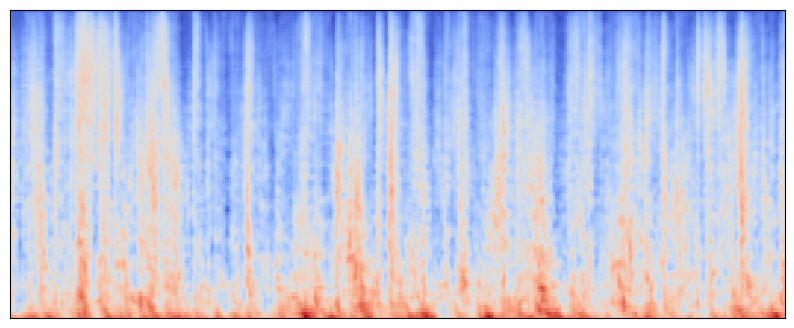

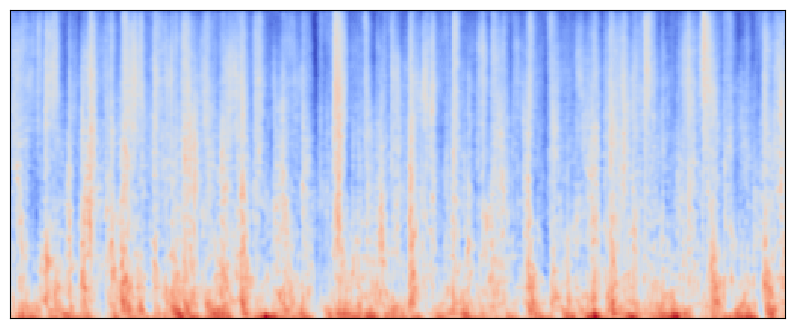

2025-06-11 16:47:12,230 - INFO - Epoch 500: Avg. Loss: 1.00947e-01 Avg. val. Loss: 1.07698e-01 Remaining Time: 00h 00min 00s LR: 1.96505e-08 


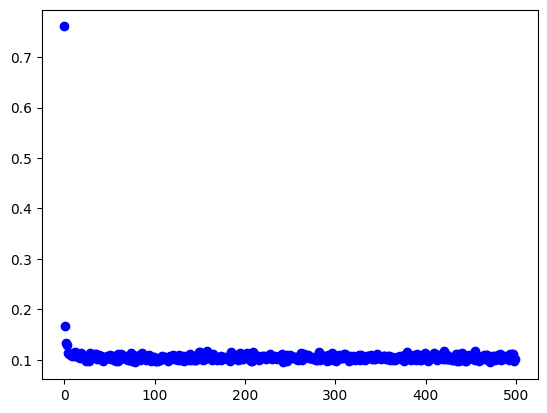

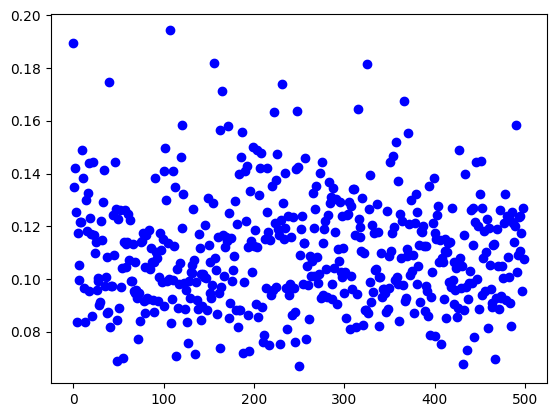

In [11]:
train_loss, val_loss = trainer.train(train_dataset=data_loader,
            val_dataset=validation_dataloader,
            n_epochs=500,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq,
            patience=-1,
            gradient_clip_norm=None,
            gradient_clip_val=None,
            sample_freq=20,
            #use_embed=False
            )
scatter_plot(train_loss)
scatter_plot(val_loss)

Save Model Architecture

In [ ]:
trainer.save_architecture(tensor_dim, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

### Sample

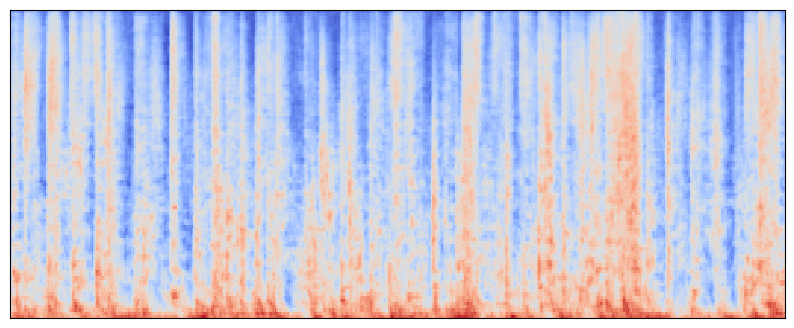

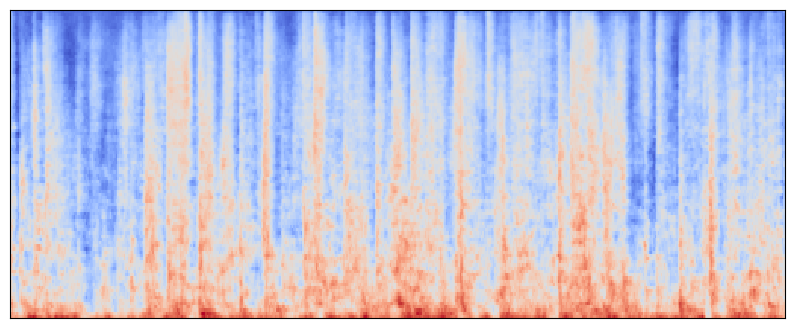

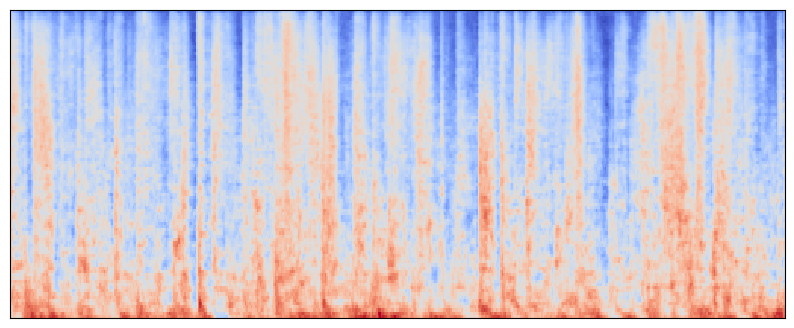

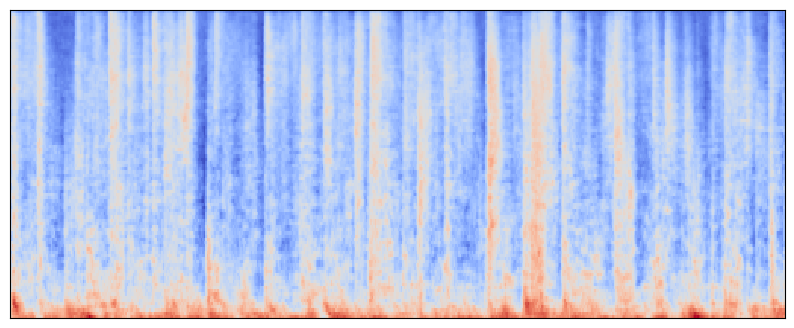

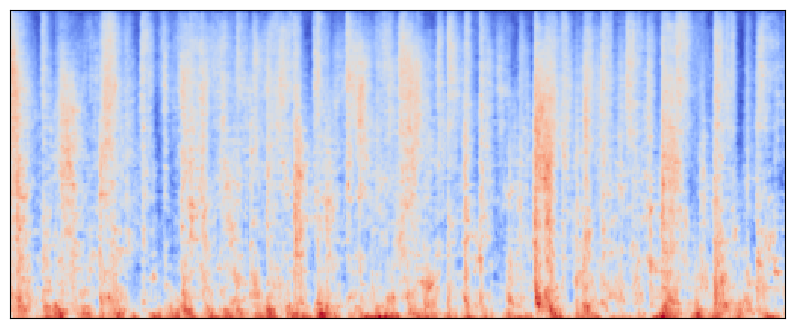

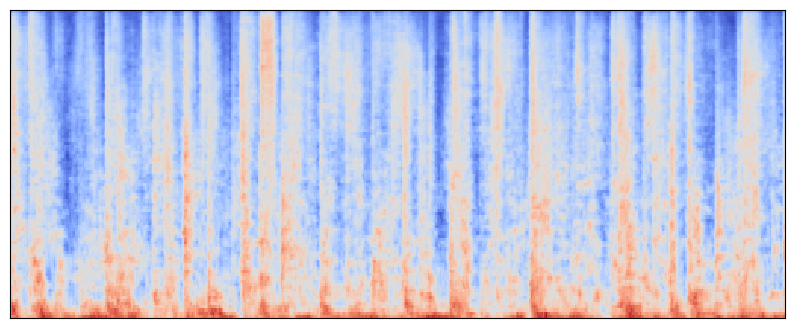

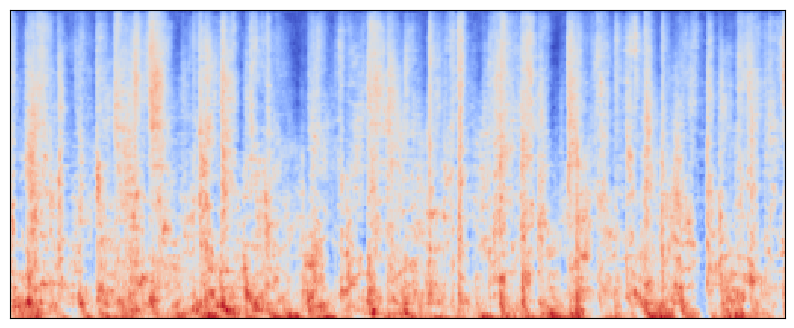

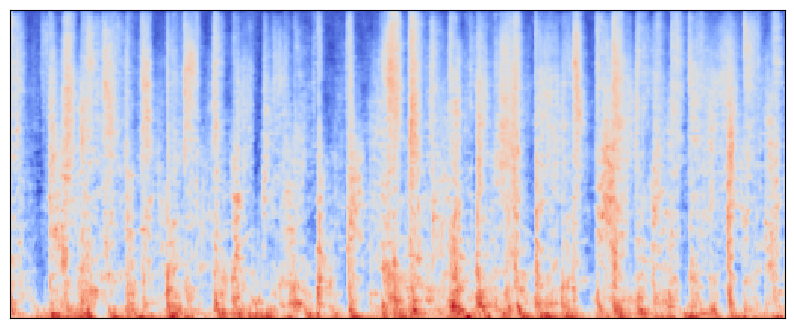

(8, 96, 512)


In [ ]:
samples = trainer.sample(8, tensor_dim, 100, True)
print(samples.shape)

In [ ]:
for i in range(samples.shape[0]):
    save_audio_file(librosa.feature.inverse.mel_to_audio(samples[i], n_fft=1023, hop_length=256, sr=32000,n_iter=300), "test_v3_{}.wav".format(i), sample_rate=32000)

In [ ]:
save_spectrogram(samples[0], "spect")

Save Samples

In [ ]:
trainer.save_samples(samples, path_to_remote_path("{}/{}".format(conf["paths"].result_path, "model_result"), remote_kernel))

Evaluate

In [ ]:
trainer.get_audio_metrics(samples, file)

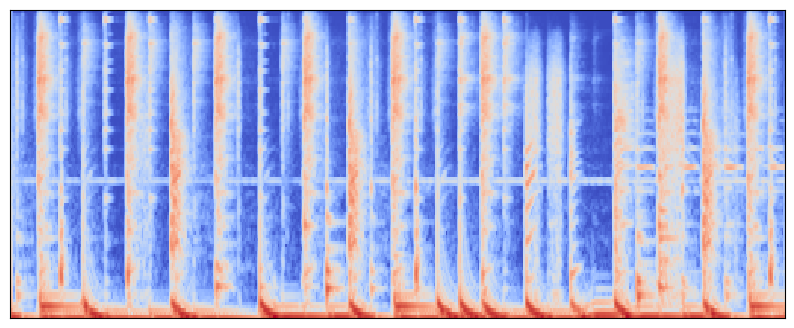

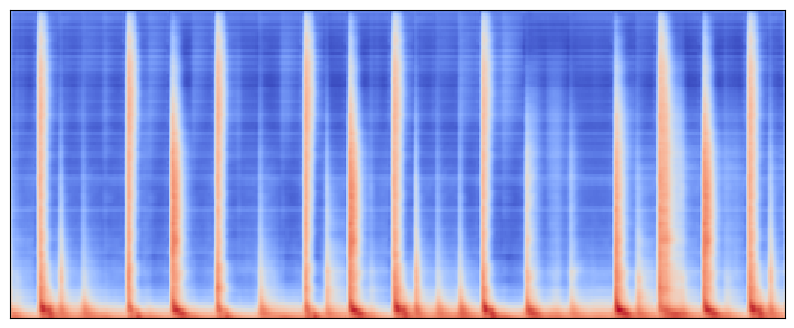

In [ ]:
visualize_spectrogram(file[100], sample_rate=32000)
save_audio_file(librosa.feature.inverse.mel_to_audio(file[100], n_fft=1023, hop_length=256, sr=32000), "test_inference_orig.wav", sample_rate=32000)
out = u_net.sample(torch.tensor(file[100]).unsqueeze(0).to(device), num_steps=1000).cpu().numpy()[0]
visualize_spectrogram(out, sample_rate=32000)
save_audio_file(librosa.feature.inverse.mel_to_audio(out, n_fft=1023, hop_length=256, sr=32000), "test_inference.wav", sample_rate=32000)